/usr/lib/python3/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


ValueError: too many values to unpack (expected 2)

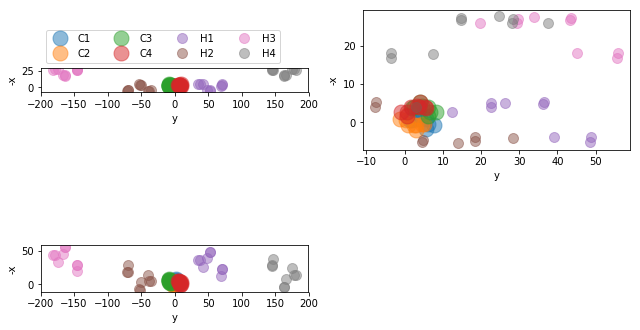

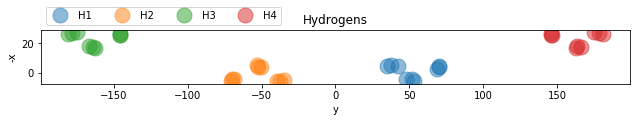

In [4]:
import numpy
import math
from matplotlib import pyplot

''' Atomic fractional coordiantes x/a, y/b, and z/c
from (1988 Macromolecules Immiczi and Iannelil) 
Comments indicate bonding. '''

C1 = numpy.array([[-0.0727, 0.2291, 0.2004],  # 0: 1
                  [-0.0765, 0.1592, 0.2788],  # 1: 0 2
                  [-0.1021, 0.1602, 0.5098],  # 2: 1 4
                  [-0.3087, 0.0589, 0.4941],  # 3: 4
                  [-0.1146, 0.0928, 0.6057],  # 4: 2 3 5
                  [-0.1044, 0.0854, 0.8428],  # 5: 4 7
                  [ 0.2775, 0.0797, 0.9260],  # 6: 7
                  [ 0.0872, 0.1156, 0.9730],  # 7: 5 6 8
                  [ 0.1026, 0.1221, 1.2109]]) # 8: 7

''' Angle between c vector and x-axis. '''
beta = 99.5 * numpy.pi / 180.0

''' Columns of unit_cell are the a, b, and c cell vectors. '''
unit_cell = numpy.array([[6.63,  0.00, 6.50*numpy.cos(beta)],
                         [0.00, 20.78, 0.0],
                         [0.00,  0.00, 6.50*numpy.sin(beta)]])


def apply_space_group(C1):
    ''' Edited symmetry operations to make figure match - not checked '''
    C2, C3, C4 = C1.copy(), C1.copy(), C1.copy()

    C2[:,0] = -C2[:,0]
    C2[:,1] = -C2[:,1]
    C2[:,2] = -C2[:,2] + 1.0

    C3[:,0] =  C3[:,0] - 0.5
    C3[:,1] =  C3[:,1] - 0.5
    C3[:,2] =  C3[:,2]

    C4[:,0] =  C4[:,0] - 0.5
    C4[:,1] = -C4[:,1] + 0.5
    C4[:,2] = -C4[:,2] + 1.0   
    
    return C1, C2, C3, C4

def apply_hydrogens(C):
    ''' Construction of hydrogens from Theodorou (MD of aPP Melts) with 
    l_H=0.11 nm and theta_H=1.28 rad and c=+1 in C1 & C4 and c=-1 in C2 & C3'''   
    
    H = numpy.empty([9,3])
    l_H = 0.11
    theta_H = 1.28
    c=1       
                  
    # Methyl Group Hydrogens    
    '''
    for i in range(7):
      for j in range(9,12):
        if j==8:
          H[i+j,0]=C[i,0]+1.037
          H[i+j,1]=C[i,1]+0.0          

        if j==9:
          H[i+j,0]=C[i,0]-0.5185
          H[i+j,1]=C[i,1]+0.898

        if j==10:
          H[i+j,0]=C[i,0]-0.5185
          H[i+j,1]=C[i,1]-0.898
          
        H[i+j,2]=C[i,2]-0.37
      i=i+3
    '''

    # Non-Methyl Hydrogens
    # Chiral hydrogen
    def chiral_H_direction(i,j,k):      
        return unit_vector(numpy.cross(C[i,:]-C[j,:], C[i,:]-C1[k,:]))

    H[0,:] = C[1,:] + c*l_H*chiral_H_direction(0,8,2)
    H[1,:] = C[4,:] + c*l_H*chiral_H_direction(3,5,2)
    H[2,:] = C[7,:] + c*l_H*chiral_H_direction(6,5,8)

    # Gemini hydrogens (C2, C5, C8 atoms) 
    # b(i) = rc(i) - rc(i-1)/|rc(i)-rc(i-1)|
    b = [None]*6
    
    # for C2
    b[0] = unit_vector(C[2,:] - C[1,:])
    b[1] = unit_vector(C[4,:] - C[2,:])

    # for C5
    b[2] = unit_vector(C[5,:] - C[4,:])
    b[3] = unit_vector(C[7,:] - C[5,:])

    # for C8
    b[4] = unit_vector(C[8,:] - C[7,:])
    C11 = C.copy()    
    C11[0,2] = C11[0,2] + 1.0 
    b[5] = unit_vector(C11[0,:] - C[8,:])


    # u(i) = (b(i) - b(i+1))/sqrt(2*(1-b(i).b(i+1))    
    u = [None]*3

    def bisector_vector(b1,b2):
        return (b1 - b2) / math.sqrt(2.0*(1.0 - numpy.dot(b1,b2)))
      
    # v(i) = (b(i) X b(i+1))/|b(i) X b(i+1)|
    v = [None]*3

    def plane_normal(b1,b2):
        return numpy.cross(b1,b2)/numpy.linalg.norm(numpy.cross(b1,b2))

    # rH(i) = rc(i) + lH*(sin(thetaH/2)*u(i) +- cos(thetaH/2)*v(i))
    def gemini_hydrogen(u,v,n):
        if n == 1:
            return (numpy.sin(theta_H/2)*u+numpy.cos(theta_H/2)*v)
        else:
            return (numpy.sin(theta_H/2)*u-numpy.cos(theta_H/2)*v)
    
    v[0] = plane_normal(b[0],b[1])
    u[0] = bisector_vector(b[0],b[1])
    H[3,:] = C[2,:]+l_H*gemini_hydrogen(u[0],v[0],1)
    H[4,:] = C[2,:]+l_H*gemini_hydrogen(u[0],v[0],2)

    v[1] = plane_normal(b[2],b[3])
    u[1] = bisector_vector(b[2],b[3])
    H[5,:] = C[5,:]+l_H*gemini_hydrogen(u[1],v[1],1)
    H[6,:] = C[5,:]+l_H*gemini_hydrogen(u[1],v[1],2)

    v[2] = plane_normal(b[4],b[5])
    u[2] = bisector_vector(b[4],b[5])
    H[7,:] = C[8,:]+l_H*gemini_hydrogen(u[2],v[2],1)
    H[8,:] = C[8,:]+l_H*gemini_hydrogen(u[2],v[2],2)   
    
    return H

    
  
def plot_unit_cell(CC):
    
    C = numpy.vstack([numpy.dot(C, unit_cell) for C in apply_space_group(CC)])
    
    lx, ly = unit_cell[0,0], unit_cell[1,1]
    H = numpy.concatenate((numpy.dot(apply_hydrogens(C[:9,:]), unit_cell),numpy.dot(apply_hydrogens(C[9:18,:]), unit_cell),
                           numpy.dot(apply_hydrogens(C[18:27,:]), unit_cell),numpy.dot(apply_hydrogens(C[27:36,:]), unit_cell)),axis=0) 

    figure = pyplot.figure(figsize=(9,5))
    aC = pyplot.subplot(221)
    aH = pyplot.subplot(221)
    
    aC.plot(C[:9,1],    -C[:9,0],    '.', ms=30, alpha=0.5, label='C1')
    aC.plot(C[9:18,1],  -C[9:18,0],  '.', ms=30, alpha=0.5, label='C2')
    aC.plot(C[18:27,1], -C[18:27,0], '.', ms=30, alpha=0.5, label='C3')
    aC.plot(C[27:36,1], -C[27:36,0], '.', ms=30, alpha=0.5, label='C4')
    aC.set_xlabel('y')
    aC.set_ylabel('-x')
    aC.set_aspect('equal')

    aH.plot(H[:9,1],    -H[:9,0],    '.', ms=20, alpha=0.5, label='H1')
    aH.plot(H[9:18,1],  -H[9:18,0],  '.', ms=20, alpha=0.5, label='H2')
    aH.plot(H[18:27,1], -H[18:27,0], '.', ms=20, alpha=0.5, label='H3')
    aH.plot(H[27:36,1], -H[27:36,0], '.', ms=20, alpha=0.5, label='H4')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')
    
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')

    aC = pyplot.subplot(222)
    aH = pyplot.subplot(222)

    aC.plot(C[:9,2],    -C[:9,0],    '.', ms=30, alpha=0.5, label='C1')
    aC.plot(C[9:18,2],  -C[9:18,0],  '.', ms=30, alpha=0.5, label='C2')
    aC.plot(C[18:27,2], -C[18:27,0], '.', ms=30, alpha=0.5, label='C3')
    aC.plot(C[27:36,2], -C[27:36,0], '.', ms=30, alpha=0.5, label='C4')
    aC.set_xlabel('z')
    aC.set_ylabel('-x')
    aC.set_aspect('equal')

    aH.plot(H[:9,2],    -H[:9,0],    '.', ms=20, alpha=0.5, label='H1')
    aH.plot(H[9:18,2],  -H[9:18,0],  '.', ms=20, alpha=0.5, label='H2')
    aH.plot(H[18:27,2], -H[18:27,0], '.', ms=20, alpha=0.5, label='H3')
    aH.plot(H[27:36,2], -H[27:36,0], '.', ms=20, alpha=0.5, label='H4')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')

    aC = pyplot.subplot(223)
    aH = pyplot.subplot(223)

    aC.plot(C[:9,1],    C[:9,2],    '.', ms=30, alpha=0.5, label='C1')
    aC.plot(C[9:18,1],  C[9:18,2],  '.', ms=30, alpha=0.5, label='C2')
    aC.plot(C[18:27,1], C[18:27,2], '.', ms=30, alpha=0.5, label='C3')
    aC.plot(C[27:36,1], C[27:36,2], '.', ms=30, alpha=0.5, label='C4')
    aC.set_xlabel('y')
    aC.set_ylabel('z')
    aC.set_aspect('equal')

    aH.plot(H[:9,1],    H[:9,2],    '.', ms=20, alpha=0.5, label='H1')
    aH.plot(H[9:18,1],  H[9:18,2],  '.', ms=20, alpha=0.5, label='H2')
    aH.plot(H[18:27,1], H[18:27,2], '.', ms=20, alpha=0.5, label='H3')
    aH.plot(H[27:36,1], H[27:36,2], '.', ms=20, alpha=0.5, label='H4')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')

    pyplot.tight_layout()

    figure1 = pyplot.figure(figsize=(9,5))
    aH = pyplot.subplot(111)
    aH.plot(H[:9,1],   -H[:9,0],      '.', ms=30, alpha=0.5, label='H1')
    aH.plot(H[9:18,1], -H[9:18,0],    '.', ms=30, alpha=0.5, label='H2')
    aH.plot(H[18:27,1],-H[18:27,0],   '.', ms=30, alpha=0.5, label='H3')
    aH.plot(H[27:36,1],-H[27:36,0],   '.', ms=30, alpha=0.5, label='H4')
    aH.set_title('Hydrogens')
    aH.set_xlabel('y')
    aH.set_ylabel('-x')
    aH.set_aspect('equal')
    pyplot.legend(ncol=4, bbox_to_anchor=(0,1), loc='lower left')
    
    pyplot.tight_layout()
    
    return C
    
def unit_vector(v):
    return v / numpy.linalg.norm(v)


def crystal(a, b, c):
    ''' Creating the initial crystalline system - a & b & c are the dimensions of the system '''    
    
    C = numpy.empty([4*a*b*c,9,3])
    H = numpy.empty([4*a*b*c,9,3])
    C11 = C1.copy()
    counter = 0   
    '''
    for i in range(a):
        C11[:,0] = C11[:,0] + 1.0*i
        counter = counter + i
        C[counter,:,:] = C11[:,:]      
        for j in range(b):
            C11[:,1] = C11[:,1] + 1.0*j
            counter = counter +j
            C[counter,:,:] = C11[:,:]
            for k in range(c):
                C11[:,2] = C11[:,2] + 1.0*k
                counter = counter + k
                C[counter,:,:] = C11[:,:]
                Temp,C[counter+1,:,:],C[counter+2,:,:],C[counter+3,:,:] = apply_space_group(C[counter,:,:]) 
                for l in range(4):
                    H = numpy.concatenate(apply_hydrogens(C[counter+l,:,:])       
                plot_unit_cell(C[counter,:,:])
                counter = counter + 3    
        C11 = C1.copy()
    return C , H'''
    
    for i in range(a):        
        C11[:,0] = C11[:,0] + 1.0*float(i)         
        C[counter,:,:] = C11[:,:].copy()        
        counter = counter + i
        Temp,C[counter+1,:,:],C[counter+2,:,:],C[counter+3,:,:] = apply_space_group(C[counter,:,:])
        for l in range(4):
            C, H = plot_unit_cell(C[counter,:,:])
            l=l+3        
        counter = counter + 3  
        C11 = C1.copy()
    
    return C , H
        
    

C , H = crystal(2,2,2)
'''
print('C coordinates')
print(format(C))
print('H coordinates')
print(H)'''

In [5]:
C11, C2, C3, C4 = apply_space_group(C1)

# Determine which carbn atoms are bonded to each other.
def carbon_bonds(C,n):
    r = numpy.dot(C, unit_cell)

    print('Carbon chain',n)
    for i in range(len((r))):
        s = '{}:'.format(i)
        for j in range(len(r)):
            d = numpy.linalg.norm(r[i,:]-r[j,:])
            if i != j and d < 1.6:
                s += ' {}'.format(j)
    print(s)

# Determine which hydrogen is connected to what carbon
def hydrogen_bonds(C,n):
    r = numpy.dot(C, unit_cell)
    H = numpy.dot(apply_hydrogens(C), unit_cell)

    print('Hydrogens of carbon chain',n)
    for i in range(len(r)):
        h1 = '{}:'.format(i)
        for j in range(len(H)):
            dist = numpy.linalg.norm(r[i,:]-H[j,:])
            if i != j and dist <= 1.1:
                h1 += '{}'.format(j)
    print(h1)

# Determine all the bonds
def bonds(C,n):
    carbon_bonds(C,n)
    hydrogen_bonds(C,n)

for i in range(len(C1)):
    bonds(C[i,:,:],i)

NameError: name 'C' is not defined

In [ ]:
# Dteremine the angle between the Carbons
C11, C2, C3, C4 = apply_space_group(C1)


def carbon_angles(C,n):
  r = numpy.dot(C, unit_cell)
  print('angles between carbons of chain',n)
  phi = [None]*4
  phi[0] = numpy.dot((C[2,:]-C[1,:]),(C[4,:]-C[2,:]))/(numpy.linalg.norm(C[2,:]-C[1,:])*numpy.linalg.norm(C[4,:]-C[2,:]))
  phi[1] = numpy.dot((C[4,:]-C[2,:]),(C[5,:]-C[4,:]))/(numpy.linalg.norm(C[4,:]-C[2,:])*numpy.linalg.norm(C[5,:]-C[4,:]))
  phi[2] = numpy.dot((C[5,:]-C[4,:]),(C[7,:]-C[5,:]))/(numpy.linalg.norm(C[5,:]-C[4,:])*numpy.linalg.norm(C[7,:]-C[5,:]))
  C[1,2] = C[1,2] + 1.0 
  phi[3] = numpy.dot((C[7,:]-C[5,:]),(C[1,:]-C[7,:]))/(numpy.linalg.norm(C[7,:]-C[5,:])*numpy.linalg.norm(C[1,:]-C[7,:]))
  print(phi,'\n')

  return phi

for i in range(len(C)):
    angles = carbon_angles(C[i,:,:],i)


In [ ]:
# Determine the Dihedral angle

def dihedral_angle(C):
    return
    